In [3]:
pip install numpy==1.26.4 torch transformers==4.48.2 scikit-learn accelerate==0.26.0 matplotlib tqdm pandas seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from tqdm import tqdm
import json

# =================== CONFIG ===================
DATA_DIR = "/workspace/SPLIT_SLIDING_FINAL/train"
OUTPUT_DIR = "/workspace/HASIL_ENCODER_KFOLD/Hasil_1"
LABEL_MAP = {'AFIB': 0, 'VFL': 1, 'VT': 2}
N_SPLITS = 5
SEED = 42
EPOCHS = 20
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 512
N_LAYERS = 12  # jumlah layer encoder
D_MODEL = 768  # dimensi hidden
N_HEAD = 12

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =================== DATA LOADING ===================
def load_data(data_dir):
    data, labels = [], []
    for label_name in os.listdir(data_dir):
        if label_name not in LABEL_MAP:
            continue
        folder_path = os.path.join(data_dir, label_name)
        for file in os.listdir(folder_path):
            if file.endswith(".npy"):
                sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
                if isinstance(sig, np.ndarray) and sig.ndim == 1:
                    data.append(sig.astype(np.float32))
                    labels.append(LABEL_MAP[label_name])
    return data, np.array(labels)

X, y = load_data(DATA_DIR)

# =================== SIGNAL TO TENSOR ===================
def signal_to_tensor(sig, target_len=MAX_LEN):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    return torch.tensor(sig, dtype=torch.float32)

X = [signal_to_tensor(sig) for sig in X]

# =================== DATASET ===================
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# =================== MODEL ===================
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim=MAX_LEN, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, num_classes=3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))  # [B, 1, D]
        x = self.encoder(x)  # [B, 1, D]
        x = x.mean(dim=1)    # [B, D]
        return self.classifier(x)

# =================== METRICS ===================
def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

# =================== K-FOLD TRAINING ===================
all_results = []
best_f1 = 0
best_fold = 0

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n[INFO] Fold {fold}")

    train_set = ECGDataset([X[i] for i in train_idx], y[train_idx])
    val_set   = ECGDataset([X[i] for i in val_idx], y[val_idx])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE)

    model = SimpleEncoder(num_classes=len(LABEL_MAP)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for xb, yb in tqdm(train_loader, desc=f"Fold {fold} Epoch {epoch}"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Epoch {epoch}] Loss: {total_loss/len(train_loader):.4f}")

    # === Evaluation ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1s = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    spec = np.mean([specificity_per_class(all_labels, all_preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])

    fold_dir = os.path.join(OUTPUT_DIR, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(fold_dir, "encoder.pt"))
    torch.save(optimizer.state_dict(), os.path.join(fold_dir, "optimizer.pt"))
    torch.save(model, os.path.join(fold_dir, "encoder_full.pth"))

    config = {
        "input_dim": MAX_LEN,
        "d_model": D_MODEL,
        "nhead": N_HEAD,
        "num_layers": N_LAYERS,
        "num_classes": len(LABEL_MAP)
    }
    with open(os.path.join(fold_dir, "encoder_config.json"), "w") as f:
        json.dump(config, f, indent=4)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
    plt.title(f"Confusion Matrix Fold {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(fold_dir, "confmat_fold.png"))
    plt.close()

    # Simpan hasil per kelas
    df_per_class = []
    for idx, label in enumerate(LABEL_MAP):
        mask_true = (np.array(all_labels) == idx).astype(int)
        mask_pred = (np.array(all_preds) == idx).astype(int)
        acc_i = accuracy_score(mask_true, mask_pred)
        rec_i = recall_score(mask_true, mask_pred, zero_division=0)
        f1_i  = f1_score(mask_true, mask_pred, zero_division=0)
        spec_i = specificity_per_class(all_labels, all_preds, idx, len(LABEL_MAP))
        df_per_class.append([fold, label, acc_i, rec_i, f1_i, spec_i])

    df_fold = pd.DataFrame(df_per_class, columns=["fold", "kelas", "akurasi", "recall", "f1 score", "spesifisitas"])
    df_fold.to_csv(os.path.join(fold_dir, f"hasil_fold{fold}.csv"), index=False)

    all_results.append(df_fold)
    if f1s > best_f1:
        best_f1 = f1s
        best_fold = fold
        shutil.copyfile(os.path.join(fold_dir, "confmat_fold.png"), os.path.join(OUTPUT_DIR, "confmat_final.png"))
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "encoder_best.pt"))
        torch.save(model, os.path.join(OUTPUT_DIR, "encoder_best_full.pth"))
        with open(os.path.join(OUTPUT_DIR, "encoder_best_config.json"), "w") as f:
            json.dump(config, f, indent=4)

# Gabungkan semua hasil
final_df = pd.concat(all_results, ignore_index=True)
final_df.to_csv(os.path.join(OUTPUT_DIR, "hasil_kfold_encoder.csv"), index=False)
print(f"[INFO] Fold terbaik berdasarkan F1-score: Fold {best_fold}")


[INFO] Fold 1


Fold 1 Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 74.04it/s]


[Epoch 1] Loss: 0.3950


Fold 1 Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 74.10it/s]


[Epoch 2] Loss: 0.1468


Fold 1 Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 74.01it/s]


[Epoch 3] Loss: 0.1327


Fold 1 Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 74.18it/s]


[Epoch 4] Loss: 0.1081


Fold 1 Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 69.86it/s]


[Epoch 5] Loss: 0.1081


Fold 1 Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 69.01it/s]


[Epoch 6] Loss: 0.0892


Fold 1 Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 68.95it/s]


[Epoch 7] Loss: 0.0759


Fold 1 Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 69.10it/s]


[Epoch 8] Loss: 0.0702


Fold 1 Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 68.92it/s]


[Epoch 9] Loss: 0.0730


Fold 1 Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 69.03it/s]


[Epoch 10] Loss: 0.0552


Fold 1 Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 68.80it/s]


[Epoch 11] Loss: 0.0527


Fold 1 Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 67.82it/s]


[Epoch 12] Loss: 0.0495


Fold 1 Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 66.84it/s]


[Epoch 13] Loss: 0.0430


Fold 1 Epoch 14: 100%|██████████| 240/240 [00:03<00:00, 65.80it/s]


[Epoch 14] Loss: 0.0507


Fold 1 Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 61.98it/s]


[Epoch 15] Loss: 0.0545


Fold 1 Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 64.98it/s]


[Epoch 16] Loss: 0.0371


Fold 1 Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 65.46it/s]


[Epoch 17] Loss: 0.0341


Fold 1 Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 65.57it/s]


[Epoch 18] Loss: 0.0323


Fold 1 Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 69.09it/s]


[Epoch 19] Loss: 0.0342


Fold 1 Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 68.48it/s]


[Epoch 20] Loss: 0.0356

[INFO] Fold 2


Fold 2 Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 63.80it/s]


[Epoch 1] Loss: 0.3309


Fold 2 Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 65.71it/s]


[Epoch 2] Loss: 0.1819


Fold 2 Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 68.01it/s]


[Epoch 3] Loss: 0.1326


Fold 2 Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 70.41it/s]


[Epoch 4] Loss: 0.1301


Fold 2 Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 69.73it/s]


[Epoch 5] Loss: 0.1084


Fold 2 Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 68.02it/s]


[Epoch 6] Loss: 0.0875


Fold 2 Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 67.04it/s]


[Epoch 7] Loss: 0.0872


Fold 2 Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 65.58it/s]


[Epoch 8] Loss: 0.0798


Fold 2 Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 66.97it/s]


[Epoch 9] Loss: 0.0665


Fold 2 Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 65.36it/s]


[Epoch 10] Loss: 0.0625


Fold 2 Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 60.81it/s]


[Epoch 11] Loss: 0.0777


Fold 2 Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 66.45it/s]


[Epoch 12] Loss: 0.0524


Fold 2 Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 66.50it/s]


[Epoch 13] Loss: 0.0531


Fold 2 Epoch 14: 100%|██████████| 240/240 [00:03<00:00, 61.04it/s]


[Epoch 14] Loss: 0.0649


Fold 2 Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 62.89it/s]


[Epoch 15] Loss: 0.0414


Fold 2 Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 68.02it/s]


[Epoch 16] Loss: 0.0388


Fold 2 Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 70.16it/s]


[Epoch 17] Loss: 0.0424


Fold 2 Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 73.52it/s]


[Epoch 18] Loss: 0.0482


Fold 2 Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 73.65it/s]


[Epoch 19] Loss: 0.0541


Fold 2 Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 73.61it/s]


[Epoch 20] Loss: 0.0428

[INFO] Fold 3


Fold 3 Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 73.23it/s]


[Epoch 1] Loss: 0.3500


Fold 3 Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 75.26it/s]


[Epoch 2] Loss: 0.1849


Fold 3 Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 75.02it/s]


[Epoch 3] Loss: 0.1472


Fold 3 Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 74.85it/s]


[Epoch 4] Loss: 0.1281


Fold 3 Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 75.08it/s]


[Epoch 5] Loss: 0.1068


Fold 3 Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 71.07it/s]


[Epoch 6] Loss: 0.1003


Fold 3 Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 70.84it/s]


[Epoch 7] Loss: 0.0899


Fold 3 Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 70.73it/s]


[Epoch 8] Loss: 0.0833


Fold 3 Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 71.69it/s]


[Epoch 9] Loss: 0.0796


Fold 3 Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 72.30it/s]


[Epoch 10] Loss: 0.0679


Fold 3 Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 72.20it/s]


[Epoch 11] Loss: 0.0658


Fold 3 Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 68.64it/s]


[Epoch 12] Loss: 0.0828


Fold 3 Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 66.16it/s]


[Epoch 13] Loss: 0.0550


Fold 3 Epoch 14: 100%|██████████| 240/240 [00:03<00:00, 67.26it/s]


[Epoch 14] Loss: 0.0507


Fold 3 Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 63.70it/s]


[Epoch 15] Loss: 0.0602


Fold 3 Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 62.20it/s]


[Epoch 16] Loss: 0.0649


Fold 3 Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 66.91it/s]


[Epoch 17] Loss: 0.0397


Fold 3 Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 68.88it/s]


[Epoch 18] Loss: 0.0348


Fold 3 Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 68.91it/s]


[Epoch 19] Loss: 0.0468


Fold 3 Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 67.49it/s]


[Epoch 20] Loss: 0.0330

[INFO] Fold 4


Fold 4 Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 68.75it/s]


[Epoch 1] Loss: 0.3829


Fold 4 Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 67.93it/s]


[Epoch 2] Loss: 0.1527


Fold 4 Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 62.17it/s]


[Epoch 3] Loss: 0.1269


Fold 4 Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 67.34it/s]


[Epoch 4] Loss: 0.1339


Fold 4 Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 66.74it/s]


[Epoch 5] Loss: 0.1061


Fold 4 Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 66.54it/s]


[Epoch 6] Loss: 0.0898


Fold 4 Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 65.50it/s]


[Epoch 7] Loss: 0.0994


Fold 4 Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 62.05it/s]


[Epoch 8] Loss: 0.0779


Fold 4 Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 66.29it/s]


[Epoch 9] Loss: 0.0730


Fold 4 Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 66.93it/s]


[Epoch 10] Loss: 0.0592


Fold 4 Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 64.54it/s]


[Epoch 11] Loss: 0.0804


Fold 4 Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 62.95it/s]


[Epoch 12] Loss: 0.0562


Fold 4 Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 62.26it/s]


[Epoch 13] Loss: 0.0581


Fold 4 Epoch 14: 100%|██████████| 240/240 [00:04<00:00, 59.64it/s]


[Epoch 14] Loss: 0.0479


Fold 4 Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 65.62it/s]


[Epoch 15] Loss: 0.0370


Fold 4 Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 61.22it/s]


[Epoch 16] Loss: 0.0459


Fold 4 Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 69.01it/s]


[Epoch 17] Loss: 0.0419


Fold 4 Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 71.14it/s]


[Epoch 18] Loss: 0.0401


Fold 4 Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 73.71it/s]


[Epoch 19] Loss: 0.0358


Fold 4 Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 73.85it/s]


[Epoch 20] Loss: 0.0376

[INFO] Fold 5


Fold 5 Epoch 1: 100%|██████████| 240/240 [00:03<00:00, 73.13it/s]


[Epoch 1] Loss: 0.3767


Fold 5 Epoch 2: 100%|██████████| 240/240 [00:03<00:00, 73.12it/s]


[Epoch 2] Loss: 0.1580


Fold 5 Epoch 3: 100%|██████████| 240/240 [00:03<00:00, 71.09it/s]


[Epoch 3] Loss: 0.1447


Fold 5 Epoch 4: 100%|██████████| 240/240 [00:03<00:00, 70.58it/s]


[Epoch 4] Loss: 0.1294


Fold 5 Epoch 5: 100%|██████████| 240/240 [00:03<00:00, 70.43it/s]


[Epoch 5] Loss: 0.1119


Fold 5 Epoch 6: 100%|██████████| 240/240 [00:03<00:00, 71.24it/s]


[Epoch 6] Loss: 0.1003


Fold 5 Epoch 7: 100%|██████████| 240/240 [00:03<00:00, 71.18it/s]


[Epoch 7] Loss: 0.0996


Fold 5 Epoch 8: 100%|██████████| 240/240 [00:03<00:00, 70.92it/s]


[Epoch 8] Loss: 0.0887


Fold 5 Epoch 9: 100%|██████████| 240/240 [00:03<00:00, 67.90it/s]


[Epoch 9] Loss: 0.0815


Fold 5 Epoch 10: 100%|██████████| 240/240 [00:03<00:00, 67.67it/s]


[Epoch 10] Loss: 0.0821


Fold 5 Epoch 11: 100%|██████████| 240/240 [00:03<00:00, 68.81it/s]


[Epoch 11] Loss: 0.0620


Fold 5 Epoch 12: 100%|██████████| 240/240 [00:03<00:00, 67.28it/s]


[Epoch 12] Loss: 0.0637


Fold 5 Epoch 13: 100%|██████████| 240/240 [00:03<00:00, 67.58it/s]


[Epoch 13] Loss: 0.0799


Fold 5 Epoch 14: 100%|██████████| 240/240 [00:03<00:00, 69.01it/s]


[Epoch 14] Loss: 0.0535


Fold 5 Epoch 15: 100%|██████████| 240/240 [00:03<00:00, 69.40it/s]


[Epoch 15] Loss: 0.0578


Fold 5 Epoch 16: 100%|██████████| 240/240 [00:03<00:00, 66.33it/s]


[Epoch 16] Loss: 0.0668


Fold 5 Epoch 17: 100%|██████████| 240/240 [00:03<00:00, 68.88it/s]


[Epoch 17] Loss: 0.0432


Fold 5 Epoch 18: 100%|██████████| 240/240 [00:03<00:00, 67.46it/s]


[Epoch 18] Loss: 0.0425


Fold 5 Epoch 19: 100%|██████████| 240/240 [00:03<00:00, 63.19it/s]


[Epoch 19] Loss: 0.0428


Fold 5 Epoch 20: 100%|██████████| 240/240 [00:03<00:00, 66.92it/s]


[Epoch 20] Loss: 0.0377
[INFO] Fold terbaik berdasarkan F1-score: Fold 3


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# === KONFIGURASI ===
TEST_DIR = "/workspace/SPLIT_SLIDING_FINAL/test"
MODEL_PATH = "/workspace/HASIL_ENCODER_KFOLD/Hasil_1/encoder_best.pt"
LABEL_MAP = {'AFIB': 0, 'VFL': 1, 'VT': 2}
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN = 512
D_MODEL = 768
N_HEAD = 12
N_LAYERS = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DEFINISI MODEL ULANG ===
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim=MAX_LEN, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, num_classes=3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))  # [B, 1, D]
        x = self.encoder(x)                 # [B, 1, D]
        x = x.mean(dim=1)                   # [B, D]
        return self.classifier(x)

# === INISIALISASI MODEL DAN LOAD STATE_DICT ===
model = SimpleEncoder(num_classes=len(LABEL_MAP)).to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

# === SIGNAL TO TENSOR ===
def signal_to_tensor(sig, target_len=MAX_LEN):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    return torch.tensor(sig, dtype=torch.float32)

# === METRIK SPESIFISITAS ===
def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

# === LOAD DATA TEST ===
X_test, y_test = [], []
for label_name in os.listdir(TEST_DIR):
    if label_name not in LABEL_MAP:
        continue
    folder_path = os.path.join(TEST_DIR, label_name)
    for file in os.listdir(folder_path):
        if file.endswith(".npy"):
            sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
            if isinstance(sig, np.ndarray) and sig.ndim == 1:
                X_test.append(signal_to_tensor(sig))
                y_test.append(LABEL_MAP[label_name])

X_test = torch.stack(X_test).to(DEVICE)
y_test = torch.tensor(y_test)

# === INFERENSI ===
with torch.no_grad():
    outputs = model(X_test)
    preds = outputs.argmax(dim=1).cpu().numpy()

# === EVALUASI ===
y_true = y_test.numpy()
acc = accuracy_score(y_true, preds)
rec = recall_score(y_true, preds, average="macro", zero_division=0)
f1s = f1_score(y_true, preds, average="macro", zero_division=0)
spec = np.mean([specificity_per_class(y_true, preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])
cm = confusion_matrix(y_true, preds)

print("\n=== Evaluation on Test Set ===")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-Score    : {f1s:.4f}")
print(f"Spesifisitas: {spec:.4f}")

# === SIMPAN CONFUSION MATRIX ===
folder_out = os.path.dirname(MODEL_PATH)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig(os.path.join(folder_out, "confmat_test.png"))
plt.close()

# === SIMPAN CSV HASIL ===
df_results = []
for idx, label in IDX2LABEL.items():
    mask_true = (y_true == idx).astype(int)
    mask_pred = (preds == idx).astype(int)
    acc_i = accuracy_score(mask_true, mask_pred)
    rec_i = recall_score(mask_true, mask_pred, zero_division=0)
    f1_i = f1_score(mask_true, mask_pred, zero_division=0)
    spec_i = specificity_per_class(y_true, preds, idx, len(LABEL_MAP))
    df_results.append([label, acc_i, rec_i, f1_i, spec_i])

df = pd.DataFrame(df_results, columns=["kelas", "akurasi", "recall", "f1 score", "spesifisitas"])
df.loc[len(df.index)] = ["FINAL", acc, rec, f1s, spec]
df.to_csv(os.path.join(folder_out, "hasil_test.csv"), index=False)


=== Evaluation on Test Set ===
Akurasi     : 0.9667
Recall      : 0.9667
F1-Score    : 0.9668
Spesifisitas: 0.9833



=== Evaluation on Test Set ===
Akurasi     : 0.9667
Recall      : 0.9667
F1-Score    : 0.9668
Spesifisitas: 0.9833


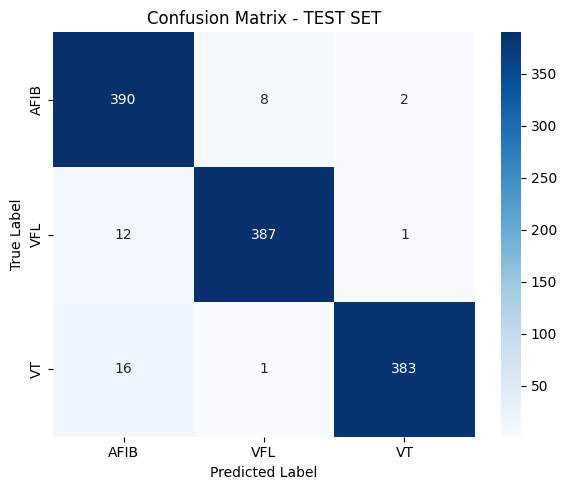


=== Evaluasi Per Kelas ===
Kelas AFIB  | Akurasi: 0.9683 | Recall: 0.9750 | F1-Score: 0.9535 | Spesifisitas: 0.9650
Kelas VFL   | Akurasi: 0.9817 | Recall: 0.9675 | F1-Score: 0.9724 | Spesifisitas: 0.9887
Kelas VT    | Akurasi: 0.9833 | Recall: 0.9575 | F1-Score: 0.9746 | Spesifisitas: 0.9962


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# === KONFIGURASI ===
TEST_DIR = "D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\SPLIT_SLIDING_FINAL\SPLIT_SLIDING_FINAL\RYTHMtest"
MODEL_PATH = "D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_TRAIN\RYTHM\Hasil_FINAL_ENCODER_RYTHM\Hasil_FINAL_ENCODER_RYTHM\encoder_best.pt"
LABEL_MAP = {'AFIB': 0, 'VFL': 1, 'VT': 2}
IDX2LABEL = {v: k for k, v in LABEL_MAP.items()}
MAX_LEN = 512
D_MODEL = 768
N_HEAD = 12
N_LAYERS = 12
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DEFINISI MODEL ULANG ===
class SimpleEncoder(nn.Module):
    def __init__(self, input_dim=MAX_LEN, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, num_classes=3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x.unsqueeze(1))  # [B, 1, D]
        x = self.encoder(x)                 # [B, 1, D]
        x = x.mean(dim=1)                   # [B, D]
        return self.classifier(x)

# === INISIALISASI MODEL DAN LOAD STATE_DICT ===
model = SimpleEncoder(num_classes=len(LABEL_MAP)).to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

# === SIGNAL TO TENSOR ===
def signal_to_tensor(sig, target_len=MAX_LEN):
    if len(sig) < target_len:
        pad = np.full(target_len - len(sig), sig[-1])
        sig = np.concatenate([sig, pad])
    else:
        idx = np.linspace(0, len(sig) - 1, target_len).astype(int)
        sig = sig[idx]
    sig = (sig - sig.min()) / (sig.ptp() + 1e-8)
    return torch.tensor(sig, dtype=torch.float32)

# === METRIK SPESIFISITAS ===
def specificity_per_class(true, pred, label, num_classes):
    cm = confusion_matrix(true, pred, labels=list(range(num_classes)))
    TN = cm.sum() - (cm[label, :].sum() + cm[:, label].sum() - cm[label, label])
    FP = cm[:, label].sum() - cm[label, label]
    return TN / (TN + FP + 1e-8)

# === LOAD DATA TEST ===
X_test, y_test = [], []
for label_name in os.listdir(TEST_DIR):
    if label_name not in LABEL_MAP:
        continue
    folder_path = os.path.join(TEST_DIR, label_name)
    for file in os.listdir(folder_path):
        if file.endswith(".npy"):
            sig = np.load(os.path.join(folder_path, file), allow_pickle=True)
            if isinstance(sig, np.ndarray) and sig.ndim == 1:
                X_test.append(signal_to_tensor(sig))
                y_test.append(LABEL_MAP[label_name])

X_test = torch.stack(X_test).to(DEVICE)
y_test = torch.tensor(y_test)

# === INFERENSI ===
with torch.no_grad():
    outputs = model(X_test)
    preds = outputs.argmax(dim=1).cpu().numpy()

# === EVALUASI AKHIR ===
y_true = y_test.numpy()
acc = accuracy_score(y_true, preds)
rec = recall_score(y_true, preds, average="macro", zero_division=0)
f1s = f1_score(y_true, preds, average="macro", zero_division=0)
spec = np.mean([specificity_per_class(y_true, preds, i, len(LABEL_MAP)) for i in range(len(LABEL_MAP))])
cm = confusion_matrix(y_true, preds)

print("\n=== Evaluation on Test Set ===")
print(f"Akurasi     : {acc:.4f}")
print(f"Recall      : {rec:.4f}")
print(f"F1-Score    : {f1s:.4f}")
print(f"Spesifisitas: {spec:.4f}")

# === SIMPAN DAN TAMPILKAN CONFUSION MATRIX ===
folder_out = "D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\HASIL_AKHIR_RECORD\RYTHM\TEST_ENCODER"
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TEST SET")
plt.tight_layout()
plt.savefig(os.path.join(folder_out, "confmat_test.png"))
plt.show()
plt.close()

# === SIMPAN DAN TAMPILKAN EVALUASI PER KELAS ===
df_results = []
print("\n=== Evaluasi Per Kelas ===")
for idx, label in IDX2LABEL.items():
    mask_true = (y_true == idx).astype(int)
    mask_pred = (preds == idx).astype(int)
    acc_i = accuracy_score(mask_true, mask_pred)
    rec_i = recall_score(mask_true, mask_pred, zero_division=0)
    f1_i = f1_score(mask_true, mask_pred, zero_division=0)
    spec_i = specificity_per_class(y_true, preds, idx, len(LABEL_MAP))
    print(f"Kelas {label:<5} | Akurasi: {acc_i:.4f} | Recall: {rec_i:.4f} | F1-Score: {f1_i:.4f} | Spesifisitas: {spec_i:.4f}")
    df_results.append([label, acc_i, rec_i, f1_i, spec_i])

# === SIMPAN KE CSV ===
df = pd.DataFrame(df_results, columns=["kelas", "akurasi", "recall", "f1 score", "spesifisitas"])
df.loc[len(df.index)] = ["FINAL", acc, rec, f1s, spec]
df.to_csv(os.path.join(folder_out, "hasil_test.csv"), index=False)

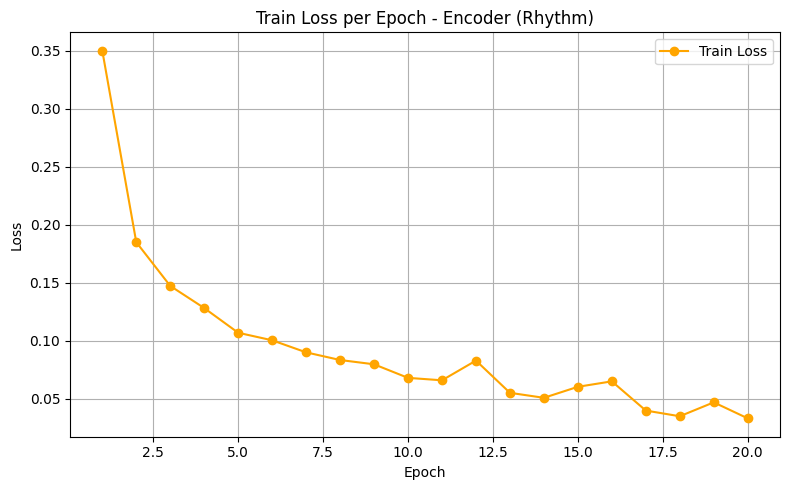

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Path lengkap ke file Excel kamu
file_path = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\Loss_encoder_rythm.xlsx"

# Baca file Excel
df = pd.read_excel(file_path)

# Buat plot Train Loss
plt.figure(figsize=(8, 5))
plt.plot(df["Epoch"], df["Train_Loss"], marker='o', label="Train Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss per Epoch - Encoder (Rhythm)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Simpan sebagai gambar PNG
output_path = r"D:\KULIAH\TELKOM_UNIVERSITY\SEMESTER_8\TA\TA_SKRIPSI_GUE\train_loss_encoder_rythm.png"
plt.savefig(output_path, dpi=300)

# Tampilkan grafik di VSCode
plt.show()